In [ ]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from sklearn.model_selection import train_test_split
from __future__ import division, print_function, absolute_import

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, pooling, AveragePooling2D, InputLayer, GlobalAveragePooling2D
from google.colab.patches import cv2_imshow
from keras import optimizers
import csv
from keras.optimizers import Adam, rmsprop, sgd
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!pip install  kaggle


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kholoudsayed","key":"6389472b7656ddb021e64dbee4200192"}'}

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=ed6040d12abbb47eb7d5f732616cf466fbb63ce365ad0b11e1fece1614ef9b1e
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection 

 99% 1.56G/1.57G [00:26<00:00, 73.3MB/s]
100% 1.57G/1.57G [00:26<00:00, 62.5MB/s]


In [ ]:
!unzip "/content/severstal-steel-defect-detection.zip"


Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images/9a83c23d1.jpg  
  inflating: train_images

In [ ]:
!ls

kaggle.json  sample_submission.csv		   test_images	train_images
sample_data  severstal-steel-defect-detection.zip  train.csv


In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


Visualize Steel Defect

In [ ]:
train= pd.read_csv("/content/train.csv")

train_files = np.sort(glob("/content/train_images/*"))
test_files  = np.sort(glob("/content/test_images/*"))
print(f"number of train images: {len(train_files)}")
print(f"number of test images: {len(test_files)}")
train.shape
train['Defect'] = train['EncodedPixels'].notnull()

train.head()
train.shape


number of train images: 12568
number of test images: 5506


(7095, 4)

In [ ]:
train = train[train.Defect]
train.shape


(7095, 4)

In [ ]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0
    
    print(tmp)

    tmp = tmp.reshape(-1,1)   
    print(tmp)
    
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [ ]:
# for test Mask 

img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)


[[0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 0]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape=(1600,256)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    #print(mask)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    #print(mask.reshape(height, width))
    #print(np.rot90( mask.reshape(height, width), k=1 ))
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [ ]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


In [ ]:
# This function uses a 1 based start index (arrays, matrixes and imgs start a index 1)
def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    print(img.reshape(shape))
    return img.reshape(shape).T


In [ ]:
res = rle2mask_eda("6 4 12 1 14 1 17 4", (5, 5))
print(res)

[[0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


In [ ]:
train['EncodedPixels'].iloc[1]


'18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63'

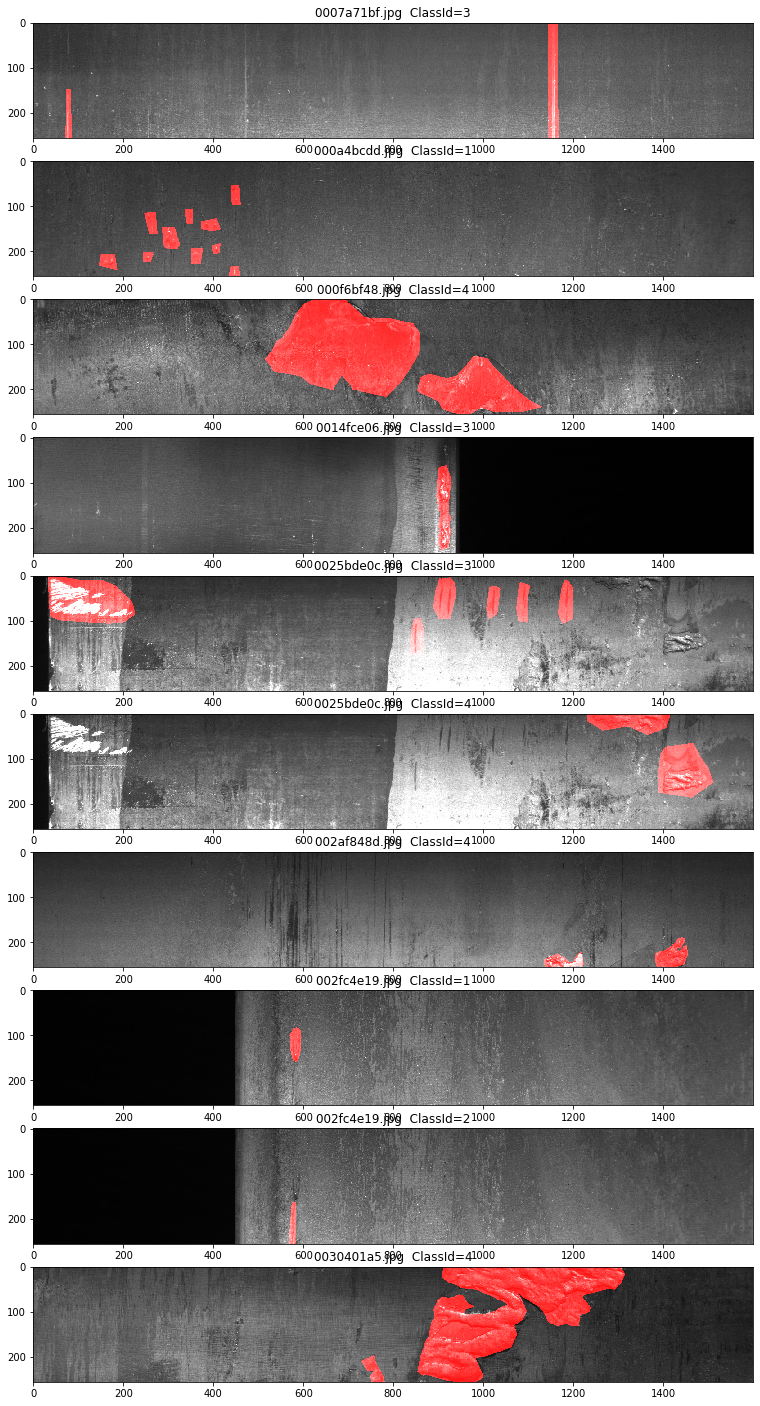

In [ ]:
rows = 10
fig = plt.figure(figsize=(25, 25))
for i in range(1,rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, 1, i).set_title(str(fn)+"  ClassId="+str(c))
    fn = train['ImageId'].iloc[i]
    img = cv2.imread( '/content/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(train['EncodedPixels'].iloc[i], img.shape)
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

Binary and Multi label Classification

In [ ]:
train= pd.read_csv("/content/train.csv")

mtr_df, mval_df = train_test_split( train, random_state=42, test_size=0.1825)
print('train_data shape:',mtr_df.shape,'val_data:',mval_df.shape)

datagen=ImageDataGenerator(rescale=1./255.,
                           shear_range=0.1,
                           zoom_range=0.1,
                           brightness_range=[0.6,1.0],
                           rotation_range=60,
                           horizontal_flip=True,
                           vertical_flip=True
                           )



train_data shape: (5800, 3) val_data: (1295, 3)


In [ ]:
columns= ['class1','class2','class3','class4']
train_gen=datagen.flow_from_dataframe(
dataframe=mtr_df,
directory="/content/train_images",
x_col="ImageId",
y_col="ClassId",
batch_size=16,
seed=42,
shuffle=False,
class_mode="other",
target_size=(299,299))

val_gen=datagen.flow_from_dataframe(
dataframe=mval_df,
directory="/content/train_images",
x_col="ImageId",
y_col="ClassId",
batch_size=16,
seed=42,
shuffle=False,
class_mode="other",
target_size=(299,299))





Found 5800 validated image filenames.
Found 1295 validated image filenames.


In [ ]:
#! kaggle datasets download -d valkling/inception-resnet-v2-weights
!kaggle datasets download -d keras/inceptionresnetv2

 98% 385M/392M [00:05<00:00, 84.9MB/s]
100% 392M/392M [00:05<00:00, 69.2MB/s]


In [ ]:
#!unzip '/content/inception-resnet-v2-weights.zip'
!unzip '/content/inceptionresnetv2.zip'

Archive:  /content/inceptionresnetv2.zip
  inflating: imagenet_class_index.json  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
from  keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#model = InceptionResNetV2(weights='imagenet', input_shape=(299,299,3), include_top=False)
from keras.layers import Dense, GlobalAveragePooling2D 


model = InceptionResNetV2(weights=None, input_shape=(299,299,3), include_top=False)
model.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.trainable=False

x=model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x) 
out=Dense(4,activation='sigmoid')(x) #final layer binary classifier

model_binary=Model(inputs=model.input,outputs=out) 

model_binary.compile(loss='categorical_crossentropy', optimizer=rmsprop(0.00001), metrics=['categorical_accuracy'])





In [ ]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_407 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_407 (BatchN (None, 149, 149, 32) 96          conv2d_407[0][0]                 
__________________________________________________________________________________________________
activation_407 (Activation)     (None, 149, 149, 32) 0           batch_normalization_407[0][0]    
________________________________________________________________________________

In [ ]:
train= pd.read_csv("/content/train.csv")

#X_train, X_test, Y_train, Y_test = train_test_split(train[''], Y, test_size=0.2, shuffle=True)